In [ ]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX,RZ,X,I,Measure
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer,MQLayer,MQAnsatzOnlyOps
from mindquantum.simulator import Simulator
from mindspore.common.initializer import Normal,initializer
from mindspore import Tensor,ops
from mindspore import dtype as mstype
from mindspore.common.parameter import Parameter
from mindspore.nn import Adam, TrainOneStepCell                   

import networkx as nx
import mindspore.nn as nn
import mindspore as ms
import mindquantum as mq
import seaborn as sns
import heapq
from math import pi


import matplotlib.pyplot as plt
import numpy as np
from math import pi
from mpl_toolkits.mplot3d import Axes3D




import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time


import warnings
warnings.filterwarnings("ignore")


import logging
import sys
import datetime
 
def init_logger(filename, logger_name):
    '''
    @brief:
        initialize logger that redirect info to a file just in case we lost connection to the notebook
    @params:
        filename: to which file should we log all the info
        logger_name: an alias to the logger
    '''
 
    # get current timestamp
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
    
    logging.basicConfig(
        level=logging.INFO, 
        format='%(message)s',
#         format='%(message)s',
        handlers=[
            logging.FileHandler(filename=filename,encoding='utf-8'),
            logging.StreamHandler(sys.stdout)
        ]
    )
 
    # Test
    logger = logging.getLogger(logger_name)
   #logger.info('### Init. Logger {} ###'.format(logger_name))
    return logger


# Initialize
my_logger = init_logger("test.log", "ml_logger")

In [2]:
# Compute the circuit depth by calling this interface

# right 2021 Huawei Technologies Co., Ltd
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================
"""DAG Circuit."""
import typing

from mindquantum.core import Circuit, gates
from mindquantum.utils.type_value_check import _check_input_type

# pylint: disable=invalid-name


class DAGNode:
    """
    Basic node in Directed Acyclic Graph.

    A DAG node has local index, which label the index of leg of node, and child nodes and father nodes.
    """

    def __init__(self):
        """Initialize a DAGNode object."""
        self.child: typing.Dict[int, "DAGNode"] = {}  # key: local index, value: child DAGNode
        self.father: typing.Dict[int, "DAGNode"] = {}  # key: local index, value: father DAGNode
        self.local: typing.List[int] = []

    def clean(self):
        """Clean node and set it to empty."""
        self.child = {}
        self.father = {}
        self.local = []

    def insert_after(self, other_node: "DAGNode"):
        """
        Insert other node after this dag node.

        Args:
            other_node (:class:`~.algorithm.compiler.DAGNode`): other DAG node.
        """
        _check_input_type("other_node", DAGNode, other_node)
        for local in self.local:
            if local in other_node.local:
                other_node.father[local] = self
                if local in self.child:
                    other_node.child[local] = self.child.get(local)
                    self.child.get(local).fathre[local] = other_node
                self.child[local] = other_node

    def insert_before(self, other_node: "DAGNode"):
        """
        Insert other node before this dag node.

        Args:
            other_node (:class:`~.algorithm.compiler.DAGNode`): other DAG node.
        """
        _check_input_type("other_node", DAGNode, other_node)
        for local in self.local:
            if local in other_node.local:
                other_node.child[local] = self
                if local in self.father:
                    other_node.father[local] = self.father.get(local)
                    self.father.get(local).child[local] = other_node
                self.father[local] = other_node


def connect_two_node(father_node: DAGNode, child_node: DAGNode, local_index: int):
    """
    Connect two DAG node through given local_index.

    Args:
        father_node (DAGNode): The father DAG node.
        child_node (DAGNode): The child DAG node.
        local_index (int): which leg you want to connect.
    """
    if local_index not in father_node.local or local_index not in child_node.local:
        raise ValueError(
            f"local_index {local_index} not in father_node" f" {father_node} or not in child_node {child_node}."
        )
    father_node.child[local_index] = child_node
    child_node.father[local_index] = father_node


class DAGQubitNode(DAGNode):
    """
    DAG node that work as quantum qubit.

    Args:
        qubit (int): id of qubit.
    """

    def __init__(self, qubit: int):
        """Initialize a DAGQubitNode object."""
        super().__init__()
        _check_input_type("qubit", int, qubit)
        self.qubit = qubit
        self.local = [qubit]

    def __str__(self):
        """Return a string representation of qubit node."""
        return f"q{self.qubit}"

    def __repr__(self):
        """Return a string representation of qubit node."""
        return self.__str__()


class GateNode(DAGNode):
    """
    DAG node that work as quantum gate.

    Args:
        gate (:class:`~.core.gates.BasicGate`): Quantum gate.
    """

    def __init__(self, gate: gates.BasicGate):
        """Initialize a GateNode object."""
        super().__init__()
        _check_input_type("gate", gates.BasicGate, gate)
        self.gate = gate
        self.local = gate.obj_qubits + gate.ctrl_qubits

    def __str__(self):
        """Return a string representation of gate node."""
        return str(self.gate)

    def __repr__(self):
        """Return a string representation of gate node."""
        return self.__str__()


class BarrierNode(GateNode):
    """DAG node that work as barrier."""

    def __init__(self, gate: gates.BasicGate, all_qubits: typing.List[int]):
        """Initialize a BarrierNode object."""
        super().__init__(gate)
        self.local = all_qubits


class DAGCircuit:
    """
    A Directed Acyclic Graph of a quantum circuit.

    Args:
        circuit (:class:`~.core.circuit.Circuit`): the input quantum circuit.

    Examples:
    from mindquantum.algorithm.compiler import DAGCircuit
    from mindquantum.core.circuit import Circuit
    circ = Circuit().h(0).x(1, 0)
    dag_circ = DAGCircuit(circ)
    dag_circ.head_node[0]
        q0
    dag_circ.head_node[0].child
        {0: H(0)}
    """

    def __init__(self, circuit: Circuit):
        """Initialize a DAGCircuit object."""
        _check_input_type("circuit", Circuit, circuit)
        self.head_node = {i: DAGQubitNode(i) for i in sorted(circuit.all_qubits.keys())}
        self.final_node = {i: DAGQubitNode(i) for i in sorted(circuit.all_qubits.keys())}
        for i in self.head_node:
            self.head_node[i].insert_after(self.final_node[i])
        for gate in circuit:
            if isinstance(gate, gates.BarrierGate):
                if gate.obj_qubits:
                    self.append_node(BarrierNode(gate, sorted(gate.obj_qubits)))
                else:
                    self.append_node(BarrierNode(gate, sorted(circuit.all_qubits.keys())))
            else:
                self.append_node(GateNode(gate))
        self.global_phase = gates.GlobalPhase(0)

    @staticmethod
    def replace_node_with_dag_circuit(node: DAGNode, coming: "DAGCircuit"):
        """
        Replace a node with a DAGCircuit.

        Args:
            node (:class:`~.algorithm.compiler.DAGNode`): the original DAG node.
            coming (:class:`~.algorithm.compiler.DAGCircuit`): the coming DAG circuit.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.core.circuit import Circuit
        circ = Circuit().x(1, 0)
        circ
            q0: ────■─────
                    ┃
                  ┏━┻━┓
            q1: ──┨╺╋╸┠───
                  ┗━━━┛
        dag_circ = DAGCircuit(circ)
        node = dag_circ.head_node[0].child[0]
        node
            X(1 <-: 0)
        sub_dag = DAGCircuit(Circuit().h(1).z(1, 0).h(1))
        DAGCircuit.replace_node_with_dag_circuit(node, sub_dag)
        dag_circ.to_circuit()
            q0: ──────────■───────────
                          ┃
                  ┏━━━┓ ┏━┻━┓ ┏━━━┓
            q1: ──┨ H ┠─┨ Z ┠─┨ H ┠───
                  ┗━━━┛ ┗━━━┛ ┗━━━┛
        """
        if set(node.local) != {head.qubit for head in coming.head_node.values()}:
            raise ValueError(f"Circuit in coming DAG is not aligned with gate in node: {node}")
        for local in node.local:
            connect_two_node(node.father[local], coming.head_node[local].child[local], local)
            connect_two_node(coming.final_node[local].father[local], node.child[local], local)

    def append_node(self, node: DAGNode):
        """
        Append a quantum gate node.

        Args:
            node (:class:`~.algorithm.compiler.DAGNode`): the DAG node you want to append.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit, GateNode
        from mindquantum.core.circuit import Circuit
        import mindquantum.core.gates as G
        circ = Circuit().h(0).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                        ┏━┻━┓
            q1: ────────┨╺╋╸┠───
                        ┗━━━┛
        dag_circ = DAGCircuit(circ)
        node = GateNode(G.RX('a').on(0, 2))
        dag_circ.append_node(node)
        dag_circ.to_circuit()
                  ┏━━━┓       ┏━━━━━━━┓
            q0: ──┨ H ┠───■───┨ RX(a) ┠───
                  ┗━━━┛   ┃   ┗━━━┳━━━┛
                        ┏━┻━┓     ┃
            q1: ────────┨╺╋╸┠─────╂───────
                        ┗━━━┛     ┃
                                  ┃
            q2: ──────────────────■───────
        """
        _check_input_type('node', DAGNode, node)
        for local in node.local:
            if local not in self.head_node:
                self.head_node[local] = DAGQubitNode(local)
                self.final_node[local] = DAGQubitNode(local)
                self.head_node[local].insert_after(self.final_node[local])
            self.final_node[local].insert_before(node)

    def depth(self) -> int:
        """
        Return the depth of quantum circuit.

        Examples:
        from mindquantum.core.circuit import Circuit
        from mindquantum.algorithm.compiler import DAGCircuit
        circ = Circuit().h(0).h(1).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        DAGCircuit(circ).depth()
            2
        """
        return len(self.layering())

    def find_all_gate_node(self) -> typing.List[GateNode]:
        """
        Find all gate node in this :class:`~.algorithm.compiler.DAGCircuit`.

        Returns:
            List[:class:`~.algorithm.compiler.GateNode`], a list of all :class:`~.algorithm.compiler.GateNode`
            of this :class:`~.algorithm.compiler.DAGCircuit`.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.core.circuit import Circuit
        circ = Circuit().h(0).x(1, 0)
        dag_circ = DAGCircuit(circ)
        dag_circ.find_all_gate_node()
            [H(0), X(1 <-: 0)]
        """
        found = set(self.head_node.values())

        def _find(current_node: DAGNode, found):
            if current_node not in found:
                found.add(current_node)
                for node in current_node.father.values():
                    _find(node, found)
                for node in current_node.child.values():
                    _find(node, found)

        for head_node in self.head_node.values():
            for current_node in head_node.child.values():
                _find(current_node, found)
        return [i for i in found if not isinstance(i, DAGQubitNode)]

    def layering(self) -> typing.List[Circuit]:
        r"""
        Layering the quantum circuit.

        Returns:
            List[:class:`~.core.circuit.Circuit`], a list of layered quantum circuit.

        Examples:
        from mindquantum.algorithm.compiler import DAGCircuit
        from mindquantum.utils import random_circuit
        circ = random_circuit(3, 5, seed=42)
        circ
                  ┏━━━━━━━━━━━━━┓   ┏━━━━━━━━━━━━━┓
            q0: ──┨             ┠─╳─┨ RY(-6.1944) ┠───────────────────
                  ┃             ┃ ┃ ┗━━━━━━┳━━━━━━┛
                  ┃ Rxx(1.2171) ┃ ┃        ┃        ┏━━━━━━━━━━━━━┓
            q1: ──┨             ┠─┃────────╂────────┨             ┠───
                  ┗━━━━━━━━━━━━━┛ ┃        ┃        ┃             ┃
                  ┏━━━━━━━━━━━━┓  ┃        ┃        ┃ Rzz(-0.552) ┃
            q2: ──┨ PS(2.6147) ┠──╳────────■────────┨             ┠───
                  ┗━━━━━━━━━━━━┛                    ┗━━━━━━━━━━━━━┛
        dag_circ = DAGCircuit(circ)
        for idx, c in enumerate(dag_circ.layering()):
            ...     print(f"layer {idx}:")
            ...     print(c)
            layer 0:
                  ┏━━━━━━━━━━━━━┓
            q0: ──┨             ┠───
                  ┃             ┃
                  ┃ Rxx(1.2171) ┃
            q1: ──┨             ┠───
                  ┗━━━━━━━━━━━━━┛
                  ┏━━━━━━━━━━━━┓
            q2: ──┨ PS(2.6147) ┠────
                  ┗━━━━━━━━━━━━┛
            layer 1:
            q0: ──╳───
                  ┃
                  ┃
            q2: ──╳───
            layer 2:
                  ┏━━━━━━━━━━━━━┓
            q0: ──┨ RY(-6.1944) ┠───
                  ┗━━━━━━┳━━━━━━┛
                         ┃
            q2: ─────────■──────────
            layer 3:
                  ┏━━━━━━━━━━━━━┓
            q1: ──┨             ┠───
                  ┃             ┃
                  ┃ Rzz(-0.552) ┃
            q2: ──┨             ┠───
                  ┗━━━━━━━━━━━━━┛
        """

        def _layering(current_node: GateNode, depth_map):
            """Layering the quantum circuit."""
            if current_node.father:
                prev_depth = []
                for father_node in current_node.father.values():
                    if father_node not in depth_map:
                        _layering(father_node, depth_map)
                    prev_depth.append(depth_map[father_node])
                depth_map[current_node] = max(prev_depth) + 1
            for child in current_node.child.values():
                if not isinstance(child, DAGQubitNode):
                    if child not in depth_map:
                        _layering(child, depth_map)

        depth_map = {i: 0 for i in self.head_node.values()}
        for current_node in self.head_node.values():
            _layering(current_node, depth_map)
        layer = [Circuit() for _ in range(len(set(depth_map.values())) - 1)]
        for k, v in depth_map.items():
            if v != 0:
                if not isinstance(k, BarrierNode):
                    layer[v - 1] += k.gate
        return [c for c in layer if len(c) != 0]

    def to_circuit(self) -> Circuit:
        """
        Convert :class:`~.algorithm.compiler.DAGCircuit` to quantum circuit.

        Returns:
            :class:`~.core.circuit.Circuit`, the quantum circuit of this DAG.

        Examples:
        from mindquantum.core.circuit import Circuit
        from mindquantum.algorithm.compiler import DAGCircuit
        circ = Circuit().h(0).h(1).x(1, 0)
        circ
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        dag_circ = DAGCircuit(circ)
        dag_circ.to_circuit()
                  ┏━━━┓
            q0: ──┨ H ┠───■─────
                  ┗━━━┛   ┃
                  ┏━━━┓ ┏━┻━┓
            q1: ──┨ H ┠─┨╺╋╸┠───
                  ┗━━━┛ ┗━━━┛
        """
        circuit = Circuit()
        considered_node = set(self.head_node.values())

        def adding_current_node(current_node, circuit, considered):
            if all(i in considered for i in current_node.father.values()) and not isinstance(
                current_node, DAGQubitNode
            ):
                circuit += current_node.gate
                considered.add(current_node)
            else:
                for node in current_node.father.values():
                    if node not in considered:
                        adding_current_node(node, circuit, considered)
                for node in current_node.child.values():
                    if node not in considered:
                        adding_current_node(node, circuit, considered)

        for current_node in self.final_node.values():
            adding_current_node(current_node, circuit, considered_node)
        return circuit

In [3]:
# Get the neighboring vertex information
def get_info_neighbors(g):
    info = {}
    
    n = len(g.nodes()) # Number of vertices in the current subgraph
    # Iterate through neighboring vertices and store their information
    for k in g.nodes():
        # Store the neighbors of vertex k
        neighbors = []
        # Iterate through the edges
        for u, v in g.edges:
            if v == k:
                neighbors.append(u)
            if u == k:
                neighbors.append(v)
        # Store vertex k and its neighbors in the dictionary info
        info[k] = neighbors
#     my_logger.info('Vertices and their neighboring vertices are: {}'.format(info))
    return info


In [4]:
def get_distance_dict(target_graph, start_vertex):
    # Compute the shortest path lengths from the start_vertex to all other vertices
    shortest_paths = nx.shortest_path_length(target_graph, source=start_vertex)

    # Create a dictionary for start_vertex, with distances as keys and lists of vertices as values
    distance_dict = {}
    for vertex, distance in shortest_paths.items():
        if distance not in distance_dict.keys(): # Check if the key 'distance' already exists, if not, create an empty list for it
            distance_dict[distance] = []
        distance_dict[distance].append(vertex)

    # Output the list of vertices grouped by distance
    print(f"Shortest paths from vertex {start_vertex} to other vertices, grouped by distance:")
    for distance, vertices in distance_dict.items():
        print(f"Vertices at distance {distance}: {vertices}")
    return distance_dict

In [5]:
def select_mixer_vertices(target_graph, root_node, N_pm):
    """
    Allocate mixers based on the distance to the root node
    Select N_pm vertices in increasing order of distance
    """
    distance_dict = get_distance_dict(target_graph, root_node)
    # Sort the vertices by distance
    sorted_nodes = []
    for distance, vertex in distance_dict.items():
        for i0 in range(0, len(vertex)):
            sorted_nodes.append(vertex[i0])  # Store all vertices at distance 'distance' from root_node

    # Select N_pm vertices to apply the mixer
    applied_mixer_nodes = []
    
    if len(sorted_nodes) >= N_pm:
        for i0 in range(0, N_pm):
            applied_mixer_nodes.append(sorted_nodes[i0])
    else:  
        for i0 in range(0, len(sorted_nodes)):
            applied_mixer_nodes.append(sorted_nodes[i0])
        
        # Find vertices that have not been selected
        candidate_n0 = []
        for node in V:
            if node not in applied_mixer_nodes:
                candidate_n0.append(node)
                    
        # Select the remaining vertices from the unselected nodes
        for i0 in range(0, N_pm - len(sorted_nodes)):
            applied_mixer_nodes.append(candidate_n0[i0])
        
    applied_mixer_nodes.sort()  # Sort the vertex IDs in ascending order to avoid errors during mixer application
    return applied_mixer_nodes


In [6]:
# Apply mixers on specific vertices and implement the corresponding unitary operation
def build_U_HM(applied_mixer_nodes, layer, target_graph, N_pm):
    
    # Initialize the quantum circuit
    cir_HM = Circuit()
    
    # Get the neighbors' information to control bit flips
    info = get_info_neighbors(target_graph) 
    
    # 'info' is a dictionary with keys as vertices and values as lists of their neighbors
    
    for node in applied_mixer_nodes:
        
        # If the node can have a mixer applied and has at least one neighbor
        if len(info[node]) != 0:
            value = info[node]  # Get the list of neighbors of node
            
            # Desired functionality: Apply RX operation on node only if all its neighbors' states are 0
            # In MindSpore Quantum, the RX gate is applied to the target qubit only when all control qubits are 1
            # To achieve this, we flip the state of all neighboring nodes first, apply a multi-controlled RX gate,
            # and then flip the states of the neighbors back to their original values
            # Flip the state of the neighbors
            for i in range(0, len(value)):
                cir_HM += X.on(value[i])
            
            # Implement the multi-qubit controlled RX gate, the target qubit is 'node', and the control qubits are 'value'
            # The RX gate is applied to the target qubit when all control qubits are in state 1
            cir_HM += RX('beta{}'.format(layer)).on(node, value)
            
            # Flip the state of the neighbors back to their original state
            for i in range(0, len(value)):
                cir_HM += X.on(value[i])

        else:
            # If the node is isolated (no neighbors), directly apply the RX gate to the node
            cir_HM += RX('beta{}'.format(layer)).on(node)
        cir_HM.barrier()
    
    return cir_HM

In [7]:
# Create the initial state, here we choose the all-zero state
def create_encoder():
    encoder = Circuit()
    return encoder



# Build the circuit U_H_D corresponding to the target Hamiltonian, parameterized by gamma
def build_U_HD(layer, g):
    # Initialize the quantum circuit
    cir_HD = Circuit()
    for v in g.nodes:
        cir_HD += RZ('gamma{}'.format(layer)).on(v)
    return cir_HD



# Build the p-layer QAOA circuit
def build_ansatz(p, target_graph, N_pm):
    
    applied_mixer_differ_layer = []  # List to store vertices where mixers are applied in different layers
    
    # Initialize the encoder with a feasible state
    encoder = create_encoder()
   
    # QAOA, p-layer ansatz: first build the circuit for the target Hamiltonian, then the initial Hamiltonian circuit
    ansatz = Circuit()
    for layer in range(1, p + 1):
        
        # The vertices where the mixer is applied vary across layers
        root_node = random.randint(0, len(V) - 1)  # Randomly choose a root node, generating a random integer in the range [0, len(V)-1]
        my_logger.info('root_node = {}'.format(root_node))
        applied_mixer_nodes = select_mixer_vertices(target_graph, root_node, N_pm)  # Get the list of vertices where the mixer can be applied
        applied_mixer_differ_layer.append(applied_mixer_nodes)
        my_logger.info('For N_pm = {}, the vertices where the mixer can be applied: {}'.format(N_pm, applied_mixer_nodes))
    
        ansatz += build_U_HD(layer, target_graph)
        ansatz += build_U_HM(applied_mixer_nodes, layer, target_graph, N_pm)
        # Add a barrier
        ansatz.barrier()

    return encoder, ansatz, applied_mixer_differ_layer



class MQAnsatzOnlyLayer(nn.Cell):
    def __init__(self, expectation_with_grad, params, weight='normal'):
        """Initialize a MQAnsatzOnlyLayer object."""
        super().__init__()
        self.evolution = MQAnsatzOnlyOps(expectation_with_grad)
        weight_size = len(self.evolution.expectation_with_grad.ansatz_params_name)
#         print('weight_size = {} '.format(weight_size))

        if isinstance(weight, ms.Tensor):
            if weight.ndim != 1 or weight.shape[0] != weight_size:
                raise ValueError(f"Weight init shape error, required ({weight_size}, ), but got {weight.shape}.")
       
        self.weight = Parameter(params.astype(np.float32), name='ansatz_weight')
        my_logger.info('weight = {}'.format(self.weight.asnumpy()))
        

    def construct(self):
        """Construct a MQAnsatzOnlyLayer node."""
        return self.evolution(self.weight)

In [8]:
# Iteration stopping condition: convergence error
def execute_function(g, layer, beta, gamma):
#     my_logger.info('layer = {},initial_beta = {},initial_gamma = {}'.format(layer,beta,gamma))
    lr = 0.05  # Learning rate
    ITR = 600  # Maximum number of iterations
    
    # Store parameters, first store gamma, then beta
    params = []
    for i in range(0, len(beta)):
        params.append(gamma[i])
        params.append(beta[i])
    
    ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
    
    # Build the QAOA circuit, where applied_mixer_differ_layer stores the vertices with applied mixers in different layers
    encoder, ansatz, applied_mixer_differ_layer = build_ansatz(layer, target_graph, N_pm)  # Generate the ansatz circuit
    circ = encoder + ansatz  # Combine the initialization circuit and the ansatz circuit into one

    
    # Due to the computational limitations of MindSpore Quantum, when the graph size exceeds 10, the DAGCircuit interface cannot compute the circuit depth
    if len(V) <= 10:
        circuit_depth_layer = DAGCircuit(circ).depth()  # Add circuit depth
    else:
        circuit_depth_layer = 0  # For calculating the total depth of all layers
        encoder0 = create_encoder()
        encoder0 += build_U_HD(1, target_graph)  # Target unitary operator
        for applied_mixer_nodes0 in applied_mixer_differ_layer:
            ansatz0 += build_U_HM(applied_mixer_nodes0, 1, target_graph, N_pm)
        temp_circ = encoder0 + ansatz0
        circuit_depth_layer += layer * DAGCircuit(temp_circ).depth()  # Add circuit depth
    
    # Convert the list into an array
    params = np.array(params)
    sim = Simulator('projectq', circ.n_qubits)  # Create simulator, backend 'mqvector' or 'projectq', simulates up to 5 qubits (the number of qubits in 'circ')
    ham = build_ham(g)
    
    grad_ops = sim.get_expectation_with_grad(ham, circ)  # Get the operator for calculating the expectation value and gradient of the variational quantum circuit
    QuantumNet = MQAnsatzOnlyLayer((grad_ops), params)
    
    opti = Adam(QuantumNet.trainable_params(), learning_rate=lr)  # The parameters to optimize are those in QuantumNet, with learning rate set to 0.05
    train_net = nn.TrainOneStepCell(QuantumNet, opti)  # Perform one step of training on the neural network
    
    my_logger.info('lr = {},ITR = {}'.format(lr, ITR))
    loss0 = []  # Store the changes in the expectation function value during training
    for i in range(0, ITR + 1):
        # train_net().asnumpy() is an array that returns the optimized expectation value, note that it is stored before measurement
        loss = train_net().asnumpy()[0]  
        loss0.append(loss)
        
        if i >= 2:
            l = len(loss0)
            delta1 = abs(loss0[l - 1] - loss0[l - 2])
            delta2 = abs(loss0[l - 2] - loss0[l - 3])
            if delta1 <= 0.001 and delta2 <= 0.001:
                my_logger.info('Convergence condition met, iteration steps used = {}, change in expectation function loss0 = {}'.format(len(loss0), loss0))
                break
            else:
                # Regarding the Hamiltonian expectation value train_net.asnumpy(), train_net() is a Tensor
                if i % 50 == 0:
                    my_logger.info("train_step = {}, loss = {}".format(i, round(loss, 5)))  # Every 50 steps, print the current training step and the current expectation value  

    
    # Retrieve the optimized parameters
    beta_opt = []
    gamma_opt = []
    params = []
    
    # Get the circuit parameters
    pr = dict(zip(ansatz.params_name, QuantumNet.weight.asnumpy()))  # Get the circuit parameters
    for key, value in pr.items():
        params.append(value)
    my_logger.info('Optimized circuit parameters params = {}'.format(params))
    my_logger.info('\n')
    
    for i in range(0, len(params)):
        if i % 2 == 0:
            gamma_opt.append(params[i])
        else:
            beta_opt.append(params[i])
       
    # Measure quantum bits
    for i in g.nodes():
        circ += Measure('q_{}'.format(i)).on(i)  # Apply a measurement on vertex i, and name the measurement 'q_{i}'
    
    result = sim.sampling(circ, pr=pr, shots=1000)  # Perform sampling with 1000 shots
    
    # Maximize the loss
    return result, gamma_opt, beta_opt, -round(loss, 5), loss0, circuit_depth_layer, applied_mixer_differ_layer


In [9]:
def global_training(ham, g, p, SEED):
    # Randomly initialize 2p circuit parameters
    # Generate a random tensor with values uniformly distributed in the range [min, max)
    # minval and maxval are Tensor types
    minval = Tensor(0, ms.float32)
    maxval = Tensor(np.pi, ms.float32)
    shape = tuple([1])
    
    # List to store initial parameters
    initial_beta = []
    initial_gamma = []

    # Randomly initialize initial parameters
    for i in range(0, p):
        param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)  # Randomly generate uniform values for beta
        initial_beta.append(param.asnumpy()[0])

        param = ops.uniform(shape, minval, maxval, seed=SEED, dtype=ms.float32)  # Randomly generate uniform values for gamma
        initial_gamma.append(param.asnumpy()[0])
    my_logger.info('SEED = {}, initial_beta = {}, initial_gamma = {}'.format(SEED, initial_beta, initial_gamma))
        
    # Parameter optimization
    # Get the optimized beta_opt and gamma_opt
    result, gamma_opt, beta_opt, loss, loss0, circuit_depth_layer, applied_mixer_differ_layer = execute_function(g, p, initial_beta, initial_gamma)
    
    return result, gamma_opt, beta_opt, loss, loss0, circuit_depth_layer, applied_mixer_differ_layer


In [10]:
# Construct the target Hamiltonian H_D, target function min C = -sum(x_i), where i = 0, 1...N-1, x_i takes values 0 or 1,
# and x_i = 1 represents that the vertex is in the subset V'
def build_ham(g):
    ham = QubitOperator()
    for i in g.nodes:
        ham += QubitOperator(f'Z{i}', 0.5)
        ham += QubitOperator(f'Z{i} Z{i}', -0.5)  # Corresponding I operator
    ham = Hamiltonian(ham)
    return ham



# Search for the max_loss and the corresponding optimized parameters for the depth-layer QAOA+ ansatz by multiple global random initializations
def search_optimized_parameters(depth, g, counts, SEED):
    
    ham = build_ham(g)  # Generate Hamiltonian   

    value = []  # Store the expectation values corresponding to each initial parameter after optimization
    params = []  # Store the optimized parameters
    measure_result = []  # Store the measurement results
    ITR = []  # Store the iteration steps consumed for each run
    circ_depth = []  # Store the circuit depth consumed for each run
    mixer_depth = []  # Store the vertices where mixers are applied in the depth-layer ansatz
    
    my_logger.info('\n\n')

    for i in range(1, counts + 1):
        my_logger.info('The {}-th global random initialization'.format(i))
        result, gamma_opt, beta_opt, loss, loss0, circuit_depth_layer, applied_mixer_differ_layer = global_training(ham, g, depth, SEED[i - 1])

        value.append(loss)
        params.append([beta_opt, gamma_opt])
        measure_result.append(result.data)
        ITR.append(len(loss0))
        circ_depth.append(circuit_depth_layer)
        mixer_depth.append(applied_mixer_differ_layer)
    
    my_logger.info('Global random initialization finished, outputting related information... ...')
    my_logger.info('value = {}'.format(value))
    my_logger.info('\n\n')

    my_logger.info('params = [[beta_optimized, gamma_optimized], ...] = {}'.format(params))
    my_logger.info('\n\n')

    my_logger.info('measure_result = {}'.format(measure_result))
    my_logger.info('\n\n')
    
    my_logger.info('consumed_iterations = {}'.format(ITR))
    my_logger.info('\n\n')
    
    # Calculate the average circuit depth
    avg_depth = 0
    for i0 in range(0, len(circ_depth)):
        avg_depth += circ_depth[i0]
    avg_depth = avg_depth / len(circ_depth)
    avg_depth = round(avg_depth, 4)
    
    # Calculate the average expectation value
    avg = 0
    for index in range(0, len(value)):
        avg += value[index]
    avg = avg / len(value)
    avg = round(avg, 5)
    my_logger.info('avg_loss = {}'.format(avg))
    
    # Calculate the average number of iterations consumed
    avg_iterations = 0
    for j in range(0, len(ITR)):
        avg_iterations += ITR[j]
    avg_iterations = avg_iterations / len(ITR)
    avg_iterations = round(avg_iterations, 5)
    my_logger.info('Average iterations consumed by multiple RI: avg_iterations = {}'.format(avg_iterations))
    
    # Calculate the number of CNOT gates required for the depth-layer ansatz mixers
    cnot_depth = []
    # Access the k0-th run
    for k0 in range(0, len(mixer_depth)):
        info = get_info_neighbors(target_graph)
        cnot_num = 0  # To calculate the total number of CNOT gates required for the current run's mixer unitary operation
        # Access the list of vertices where mixers are applied in the k1-th layer of ansatz
        for k1 in range(0, len(mixer_depth[k0])):
            # Access specific vertices where mixers are applied
            for k2 in range(0, len(mixer_depth[k0][k1])):
                d = len(info[mixer_depth[k0][k1][k2]])  # Get the number of neighboring nodes of the mixer vertex

                # Convert d-qubit controlled RX gates to basic gates and calculate the number of CNOT gates required
                if d == 1:
                    cnot_num += 2
                if d == 2:
                    cnot_num += 6
                if d == 3:
                    cnot_num += 18
                if d == 4:
                    cnot_num += 42
                if d >= 5:
                    cnot_num += 16 * d - 8
        cnot_depth.append(cnot_num)  # Append the number of CNOT gates required for implementing the depth-layer mixer unitary operations
    my_logger.info('depth = {}, {} optimization runs, the number of CNOT gates required for each run = {}'.format(depth, counts, cnot_depth))  
    my_logger.info('\n\n')
    
    # Calculate the average number of CNOT gates required for a single run at depth-layer level
    avg_cnot = 0
    for i0 in range(0, len(cnot_depth)):
        avg_cnot += cnot_depth[i0]
    avg_cnot = avg_cnot / len(cnot_depth)
    avg_cnot = round(avg_cnot, 4)
    
    # The maximum loss obtained from multiple random initializations
    max_loss = max(value)
    my_logger.info('max_loss = {}'.format(max_loss))
    params_opt = []  # Store the optimized parameters corresponding to max_loss
    SEED_opt = []  # Store the SEEDs corresponding to max_loss

    for j in range(0, len(value)):
        if value[j] == max_loss:
            params_opt.append(params[j])
            SEED_opt.append(SEED[j])
    my_logger.info('params_opt = {}'.format(params_opt))
    my_logger.info('\n')
    my_logger.info('SEED_opt = {}'.format(SEED_opt))
    
    return params_opt, max_loss, avg, value, avg_iterations, avg_depth, avg_cnot


In [11]:
# 20 Erdős–Rényi graphs with 8 vertices, probability = 0.5
# E0 = [[(0, 3), (0, 5), (1, 2), (1, 3), (1, 4), (1, 6), (2, 3), (2, 5), (2, 7), (5, 7), (6, 7)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (1, 3), (1, 4), (1, 5), (1, 7), (2, 3), (2, 6), (3, 4), (3, 5), (4, 7), (5, 6), (5, 7)], [(0, 1), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 5), (2, 6), (2, 7), (3, 4), (3, 5), (4, 5), (5, 6), (6, 7)], [(0, 1), (0, 2), (0, 4), (0, 6), (0, 7), (1, 4), (1, 5), (1, 7), (2, 3), (2, 5), (2, 6), (2, 7), (3, 5), (4, 6), (5, 6), (5, 7)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (2, 4), (3, 4), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7)], [(0, 1), (0, 3), (0, 4), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (2, 4), (3, 4), (4, 5), (5, 7), (6, 7)], [(0, 1), (0, 3), (0, 6), (1, 2), (1, 4), (1, 6), (1, 7), (2, 4), (2, 6), (2, 7), (3, 5), (3, 6), (4, 7)], [(0, 1), (0, 2), (0, 6), (0, 7), (1, 6), (1, 7), (2, 4), (2, 5), (2, 7), (3, 4), (3, 5), (3, 6), (4, 6), (4, 7), (6, 7)], [(0, 2), (0, 4), (0, 7), (1, 3), (1, 5), (2, 5), (2, 6), (3, 5), (3, 6), (3, 7), (4, 5), (5, 6), (5, 7)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 5), (1, 6), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (3, 7), (4, 7), (5, 7)], [(0, 2), (0, 3), (1, 3), (1, 4), (1, 6), (2, 3), (2, 4), (2, 6), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7)], [(0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), (1, 4), (2, 3), (2, 5), (2, 6), (3, 5), (3, 6), (6, 7)], [(0, 1), (0, 2), (0, 3), (0, 5), (1, 2), (1, 6), (2, 4), (2, 5), (2, 7), (3, 6), (4, 5), (4, 7), (5, 7)], [(0, 1), (0, 2), (0, 6), (1, 2), (1, 4), (2, 7), (3, 6), (4, 6), (5, 6), (5, 7)], [(0, 1), (0, 3), (0, 6), (1, 2), (1, 3), (1, 6), (1, 7), (2, 3), (2, 5), (2, 7), (4, 7), (6, 7)], [(0, 2), (0, 4), (0, 6), (1, 2), (1, 4), (1, 5), (1, 7), (2, 4), (2, 5), (2, 6), (3, 4), (4, 5), (4, 6), (4, 7), (5, 6), (6, 7)], [(0, 1), (0, 6), (1, 2), (1, 3), (2, 6), (2, 7), (3, 4), (3, 6), (4, 5), (4, 6), (4, 7), (5, 7)], [(0, 2), (0, 4), (0, 5), (0, 6), (0, 7), (1, 3), (1, 4), (2, 4), (2, 6), (3, 5), (4, 5), (5, 6)], [(0, 2), (1, 2), (1, 4), (1, 6), (2, 6), (2, 7), (3, 4), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (6, 7)], [(0, 2), (0, 3), (0, 4), (0, 7), (1, 2), (1, 3), (1, 5), (2, 4), (2, 6), (3, 4), (3, 6), (3, 7), (4, 6), (4, 7), (5, 6), (5, 7)]]

# 20 3-regular graphs with 8 vertices
E0 = [[(1, 2), (1, 4), (1, 6), (2, 5), (2, 0), (4, 6), (4, 3), (6, 5), (5, 7), (7, 0), (7, 3), (0, 3)], [(2, 7), (2, 3), (2, 0), (7, 4), (7, 6), (0, 1), (0, 5), (1, 4), (1, 6), (4, 3), (6, 5), (5, 3)], [(2, 7), (2, 1), (2, 4), (7, 6), (7, 3), (1, 5), (1, 6), (6, 5), (5, 0), (0, 4), (0, 3), (4, 3)], [(2, 7), (2, 6), (2, 0), (7, 4), (7, 0), (0, 1), (1, 3), (1, 4), (4, 5), (6, 5), (6, 3), (3, 5)], [(0, 1), (0, 6), (0, 3), (1, 2), (1, 3), (2, 7), (2, 4), (7, 5), (7, 3), (4, 6), (4, 5), (6, 5)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 3), (4, 7), (4, 5), (7, 6), (7, 5), (3, 0), (6, 0), (5, 0)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 4), (6, 7), (6, 0), (7, 5), (7, 3), (3, 0), (4, 5), (5, 0)], [(2, 7), (2, 5), (2, 0), (7, 4), (7, 3), (0, 1), (0, 4), (1, 3), (1, 6), (4, 6), (3, 5), (6, 5)], [(1, 2), (1, 0), (1, 7), (2, 6), (2, 0), (0, 5), (6, 7), (6, 4), (7, 3), (4, 5), (4, 3), (5, 3)], [(1, 3), (1, 5), (1, 7), (3, 2), (3, 7), (6, 7), (6, 4), (6, 5), (4, 0), (4, 2), (5, 0), (0, 2)], [(1, 2), (1, 4), (1, 6), (2, 6), (2, 5), (4, 7), (4, 3), (7, 6), (7, 0), (0, 3), (0, 5), (3, 5)], [(1, 3), (1, 6), (1, 7), (3, 2), (3, 0), (4, 6), (4, 5), (4, 2), (6, 0), (5, 7), (5, 2), (7, 0)], [(2, 7), (2, 5), (2, 4), (7, 0), (7, 3), (0, 1), (0, 6), (1, 3), (1, 5), (3, 6), (4, 6), (4, 5)], [(0, 1), (0, 2), (0, 7), (1, 6), (1, 7), (4, 7), (4, 3), (4, 2), (5, 6), (5, 2), (5, 3), (6, 3)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 4), (4, 7), (7, 6), (7, 0), (3, 0), (3, 5), (6, 5), (5, 0)], [(1, 3), (1, 4), (1, 7), (3, 2), (3, 5), (6, 7), (6, 5), (6, 0), (7, 0), (5, 2), (4, 0), (4, 2)], [(1, 2), (1, 3), (1, 5), (2, 7), (2, 6), (7, 4), (7, 0), (4, 6), (4, 0), (3, 6), (3, 5), (0, 5)], [(0, 1), (0, 7), (0, 6), (1, 5), (1, 6), (4, 7), (4, 3), (4, 2), (7, 5), (2, 6), (2, 3), (5, 3)], [(4, 7), (4, 1), (4, 0), (7, 1), (7, 3), (5, 6), (5, 0), (5, 2), (6, 1), (6, 3), (2, 3), (2, 0)], [(2, 7), (2, 1), (2, 3), (7, 0), (7, 3), (1, 5), (1, 6), (4, 6), (4, 5), (4, 0), (6, 5), (0, 3)]]

In [12]:
# 20 Erdős–Rényi graphs with 10 vertices, probability = 0.5
# E0 = [[(0, 2), (0, 3), (0, 5), (1, 2), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (4, 5), (4, 6), (5, 6), (6, 7), (6, 9), (7, 8)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 6), (2, 7), (2, 8), (3, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 9), (6, 9), (8, 9)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 5), (1, 9), (2, 6), (3, 7), (4, 6), (4, 8), (5, 8), (5, 9), (6, 8), (7, 9), (8, 9)], [(0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 6), (2, 9), (3, 4), (3, 5), (3, 6), (3, 8), (4, 8), (4, 9), (5, 7), (6, 7), (6, 9), (7, 8), (8, 9)], [(0, 2), (0, 4), (0, 5), (0, 7), (1, 7), (1, 9), (2, 4), (2, 7), (2, 8), (3, 8), (4, 8), (4, 9), (6, 8), (8, 9)], [(0, 2), (0, 4), (0, 5), (0, 6), (0, 9), (1, 3), (1, 4), (1, 6), (2, 3), (2, 4), (2, 5), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 9), (4, 6), (4, 7), (4, 8), (5, 6), (6, 8), (7, 8), (7, 9)], [(0, 1), (0, 4), (0, 5), (0, 8), (0, 9), (1, 5), (1, 9), (2, 7), (2, 8), (3, 5), (3, 8), (3, 9), (4, 5), (4, 6), (4, 8), (5, 7), (5, 8), (6, 7), (6, 9)], [(0, 1), (0, 3), (0, 5), (0, 9), (1, 4), (1, 7), (1, 8), (2, 3), (2, 6), (2, 7), (2, 8), (2, 9), (3, 6), (3, 7), (3, 9), (4, 5), (4, 6), (4, 7), (4, 9), (5, 7), (6, 7), (6, 8), (7, 9), (8, 9)], [(0, 1), (0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 9), (3, 4), (3, 8), (4, 8), (6, 7), (6, 9), (7, 8)], [(0, 1), (0, 5), (0, 6), (0, 9), (1, 2), (1, 7), (1, 8), (1, 9), (2, 4), (2, 7), (2, 8), (2, 9), (3, 4), (3, 6), (3, 8), (3, 9), (4, 5), (4, 7), (5, 9), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)], [(0, 2), (0, 5), (0, 8), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (2, 6), (2, 8), (3, 5), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 8), (5, 9), (6, 7), (6, 8)], [(0, 2), (0, 4), (0, 6), (0, 7), (0, 8), (1, 2), (1, 3), (1, 8), (1, 9), (2, 6), (2, 7), (2, 8), (3, 6), (3, 8), (4, 6), (4, 8), (4, 9), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (8, 9)], [(0, 1), (0, 5), (0, 7), (1, 2), (1, 5), (1, 6), (1, 7), (1, 9), (2, 3), (2, 4), (2, 5), (2, 9), (3, 4), (3, 6), (3, 7), (3, 8), (4, 6), (4, 7), (5, 8), (5, 9), (6, 8)], [(0, 1), (0, 5), (0, 7), (1, 2), (1, 5), (1, 6), (1, 7), (1, 9), (2, 3), (2, 4), (2, 5), (2, 9), (3, 4), (3, 6), (3, 7), (3, 8), (4, 6), (4, 7), (5, 8), (5, 9), (6, 8)], [(0, 1), (0, 4), (0, 6), (1, 2), (1, 3), (1, 4), (1, 7), (1, 9), (3, 7), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (6, 7), (7, 8), (7, 9), (8, 9)], [(0, 3), (0, 4), (0, 6), (1, 2), (1, 6), (1, 7), (1, 9), (2, 5), (2, 7), (2, 8), (2, 9), (3, 4), (3, 8), (4, 6), (4, 7), (4, 9), (5, 6), (5, 8), (6, 7), (6, 8), (6, 9), (8, 9)], [(0, 3), (0, 4), (0, 5), (0, 7), (0, 9), (1, 2), (1, 3), (1, 7), (1, 9), (2, 3), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 7), (4, 6), (5, 7), (5, 8), (5, 9), (6, 8), (7, 8), (7, 9), (8, 9)], [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 9), (1, 2), (1, 7), (1, 8), (2, 4), (2, 5), (2, 7), (3, 5), (3, 7), (3, 8), (3, 9), (4, 6), (4, 7), (5, 6), (5, 8), (5, 9), (6, 8), (6, 9)], [(0, 5), (0, 9), (1, 5), (1, 7), (1, 9), (2, 5), (3, 5), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (6, 7)], [(0, 4), (0, 5), (1, 2), (1, 4), (1, 5), (1, 6), (1, 8), (2, 4), (2, 5), (2, 7), (3, 4), (3, 5), (3, 6), (3, 9), (4, 6), (4, 7), (5, 6), (5, 7), (5, 8), (6, 8), (7, 8), (7, 9), (8, 9)]]

# 20 3-regular graphs with 10 vertices
# E0 = [[(1, 2), (1, 5), (1, 8), (2, 6), (2, 5), (6, 4), (6, 3), (4, 3), (4, 0), (0, 7), (0, 9), (7, 8), (7, 9), (5, 8), (3, 9)], [(2, 7), (2, 8), (2, 0), (7, 1), (7, 3), (4, 9), (4, 6), (4, 5), (9, 8), (9, 1), (6, 5), (6, 0), (5, 1), (8, 3), (0, 3)], [(6, 7), (6, 5), (6, 3), (7, 0), (7, 8), (4, 9), (4, 1), (4, 0), (9, 2), (9, 0), (2, 3), (2, 5), (5, 1), (1, 8), (3, 8)], [(2, 7), (2, 4), (2, 0), (7, 4), (7, 9), (0, 1), (0, 5), (1, 5), (1, 6), (4, 8), (8, 9), (8, 3), (5, 6), (6, 3), (9, 3)], [(1, 2), (1, 0), (1, 8), (2, 9), (2, 4), (0, 7), (0, 8), (6, 9), (6, 5), (6, 3), (9, 7), (4, 8), (4, 5), (5, 3), (7, 3)], [(0, 1), (0, 5), (0, 4), (1, 3), (1, 9), (7, 8), (7, 6), (7, 4), (8, 2), (8, 3), (6, 9), (6, 5), (9, 2), (3, 4), (2, 5)], [(5, 9), (5, 0), (5, 2), (9, 3), (9, 0), (4, 7), (4, 8), (4, 1), (7, 6), (7, 1), (2, 6), (2, 0), (6, 3), (8, 3), (8, 1)], [(0, 1), (0, 9), (0, 3), (1, 2), (1, 4), (2, 8), (2, 4), (6, 9), (6, 4), (6, 5), (9, 7), (5, 7), (5, 8), (8, 3), (7, 3)], [(2, 7), (2, 6), (2, 0), (7, 4), (7, 8), (5, 9), (5, 0), (5, 8), (9, 4), (9, 0), (4, 3), (1, 3), (1, 8), (1, 6), (3, 6)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 5), (7, 8), (7, 6), (7, 3), (8, 9), (8, 0), (6, 9), (9, 0), (3, 4), (4, 5), (5, 0)], [(0, 1), (0, 3), (0, 8), (1, 5), (1, 6), (6, 9), (6, 5), (9, 8), (9, 7), (4, 7), (4, 5), (4, 2), (7, 3), (2, 8), (2, 3)], [(2, 7), (2, 6), (2, 3), (7, 3), (7, 8), (0, 1), (0, 5), (0, 9), (1, 4), (1, 9), (6, 9), (6, 4), (4, 8), (8, 5), (5, 3)], [(5, 9), (5, 6), (5, 7), (9, 8), (9, 3), (4, 6), (4, 1), (4, 0), (6, 1), (2, 8), (2, 3), (2, 0), (8, 7), (7, 1), (3, 0)], [(2, 7), (2, 1), (2, 8), (7, 5), (7, 0), (5, 9), (5, 6), (9, 6), (9, 3), (1, 3), (1, 8), (3, 0), (6, 4), (4, 8), (4, 0)], [(6, 9), (6, 2), (6, 1), (9, 8), (9, 3), (2, 5), (2, 3), (4, 7), (4, 8), (4, 0), (7, 5), (7, 1), (8, 1), (5, 0), (0, 3)], [(1, 2), (1, 3), (1, 4), (2, 6), (2, 9), (5, 9), (5, 4), (5, 0), (9, 8), (6, 8), (6, 3), (3, 7), (8, 7), (4, 0), (0, 7)], [(1, 2), (1, 6), (1, 7), (2, 6), (2, 0), (6, 9), (9, 4), (9, 8), (4, 0), (4, 3), (5, 7), (5, 8), (5, 3), (7, 0), (3, 8)], [(5, 9), (5, 0), (5, 3), (9, 6), (9, 2), (6, 7), (6, 0), (7, 0), (7, 1), (2, 8), (2, 4), (8, 3), (8, 1), (1, 4), (4, 3)], [(4, 7), (4, 9), (4, 0), (7, 6), (7, 1), (1, 3), (1, 6), (3, 8), (3, 5), (6, 0), (9, 2), (9, 0), (2, 8), (2, 5), (8, 5)], [(1, 2), (1, 9), (1, 7), (2, 3), (2, 4), (6, 9), (6, 7), (6, 3), (9, 4), (4, 5), (7, 8), (5, 0), (5, 8), (3, 0), (0, 8)]]


In [13]:
# 20 Erdős–Rényi graphs with 12 vertices, probability = 0.5
# E0 = [[(0, 1), (0, 3), (0, 6), (0, 7), (0, 10), (0, 11), (1, 6), (1, 8), (1, 10), (2, 3), (2, 4), (2, 10), (2, 11), (3, 7), (3, 8), (3, 9), (4, 6), (4, 9), (4, 10), (5, 6), (5, 8), (5, 11), (6, 11), (7, 8), (7, 11), (8, 9), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (1, 2), (1, 5), (1, 6), (1, 7), (1, 8), (2, 6), (2, 7), (2, 9), (2, 11), (3, 4), (3, 5), (3, 6), (3, 9), (3, 10), (3, 11), (4, 6), (4, 9), (5, 6), (5, 7), (5, 8), (5, 10), (5, 11), (6, 9), (7, 8), (7, 9), (7, 10), (7, 11), (8, 9), (8, 11)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 9), (0, 10), (0, 11), (1, 2), (1, 3), (1, 5), (1, 6), (1, 9), (1, 10), (1, 11), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 5), (3, 6), (3, 11), (4, 5), (5, 6), (5, 8), (5, 9), (5, 11), (6, 7), (6, 8), (6, 10), (6, 11), (7, 10), (7, 11), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11)], [(0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 9), (1, 11), (2, 4), (2, 5), (2, 7), (2, 9), (2, 10), (2, 11), (3, 5), (3, 8), (3, 11), (4, 6), (4, 7), (4, 8), (4, 10), (4, 11), (5, 7), (5, 8), (5, 9), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10), (7, 11), (8, 11)], [(0, 1), (0, 2), (0, 4), (0, 7), (0, 8), (0, 11), (1, 6), (1, 7), (1, 8), (1, 9), (1, 11), (2, 5), (2, 6), (2, 7), (3, 4), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 11), (5, 7), (5, 8), (5, 10), (6, 10), (6, 11), (7, 8), (8, 9), (9, 10)], [(0, 2), (0, 3), (0, 4), (0, 6), (0, 7), (0, 8), (0, 11), (1, 4), (1, 6), (2, 7), (3, 7), (3, 8), (3, 9), (4, 5), (4, 9), (4, 11), (5, 6), (5, 10), (6, 7), (6, 9), (6, 10), (6, 11), (7, 8), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 6), (0, 11), (1, 2), (1, 5), (1, 6), (1, 8), (1, 9), (1, 10), (2, 4), (2, 6), (2, 9), (3, 5), (3, 7), (3, 8), (3, 10), (4, 5), (4, 10), (4, 11), (5, 7), (6, 7), (6, 8), (6, 9), (7, 8), (7, 10), (8, 10), (8, 11), (10, 11)], [(0, 2), (0, 7), (0, 10), (0, 11), (1, 2), (1, 5), (1, 7), (1, 10), (1, 11), (2, 5), (3, 6), (3, 9), (3, 10), (3, 11), (4, 5), (4, 7), (4, 8), (4, 9), (4, 10), (5, 8), (5, 9), (6, 11), (7, 8), (7, 10), (8, 9), (8, 10), (9, 11)], [(0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (1, 2), (1, 4), (1, 7), (1, 8), (2, 3), (2, 8), (2, 10), (2, 11), (3, 8), (3, 11), (4, 5), (4, 7), (4, 9), (5, 7), (5, 10), (5, 11), (6, 10), (9, 11), (10, 11)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 9), (0, 11), (1, 5), (1, 6), (1, 8), (1, 9), (1, 10), (1, 11), (2, 5), (2, 7), (2, 10), (3, 4), (3, 5), (3, 6), (3, 7), (3, 10), (4, 8), (4, 9), (4, 10), (4, 11), (5, 6), (6, 7), (6, 8), (6, 9), (6, 11), (7, 8), (7, 9), (7, 10), (7, 11), (8, 10), (9, 10)], [(0, 1), (0, 3), (0, 5), (0, 6), (0, 7), (0, 9), (0, 11), (1, 7), (1, 9), (1, 11), (2, 5), (2, 7), (2, 8), (2, 9), (2, 10), (3, 10), (3, 11), (4, 6), (4, 7), (4, 8), (4, 11), (5, 6), (5, 10), (7, 9), (9, 10), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 9), (0, 10), (0, 11), (1, 4), (1, 7), (1, 9), (1, 11), (2, 6), (2, 7), (2, 9), (2, 11), (4, 5), (4, 7), (4, 8), (4, 11), (5, 7), (5, 10), (5, 11), (6, 11), (7, 9), (7, 10), (7, 11), (8, 11), (9, 10), (9, 11)], [(0, 1), (0, 2), (0, 6), (0, 8), (0, 9), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 6), (1, 8), (1, 9), (1, 10), (1, 11), (2, 4), (2, 10), (2, 11), (3, 5), (3, 6), (3, 7), (3, 9), (3, 10), (3, 11), (4, 5), (5, 9), (5, 11), (6, 10), (7, 9), (7, 10), (9, 10), (9, 11), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 10), (0, 11), (1, 5), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 4), (2, 8), (2, 11), (3, 4), (3, 10), (3, 11), (4, 5), (4, 6), (4, 9), (4, 10), (4, 11), (5, 7), (5, 9), (5, 11), (6, 7), (6, 9), (6, 10), (6, 11), (7, 10), (8, 10), (9, 10), (9, 11), (10, 11)], [(0, 3), (0, 6), (0, 8), (0, 10), (0, 11), (1, 4), (1, 5), (1, 6), (1, 9), (1, 11), (2, 6), (2, 7), (2, 9), (2, 11), (3, 5), (3, 6), (3, 7), (3, 8), (3, 11), (4, 6), (4, 7), (4, 8), (4, 11), (5, 6), (5, 7), (5, 10), (6, 8), (6, 10), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11)], [(0, 1), (0, 2), (0, 5), (0, 8), (0, 9), (0, 10), (0, 11), (1, 3), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 3), (2, 9), (2, 10), (3, 5), (3, 7), (3, 9), (3, 10), (5, 7), (5, 10), (5, 11), (6, 7), (6, 10), (7, 10), (8, 11), (9, 10), (9, 11)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (0, 9), (1, 3), (1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 4), (2, 5), (2, 6), (2, 9), (2, 10), (3, 8), (3, 9), (3, 10), (3, 11), (4, 5), (4, 7), (4, 9), (4, 10), (5, 9), (5, 11), (7, 9), (7, 10), (7, 11), (10, 11)], [(0, 1), (0, 4), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (1, 2), (1, 3), (1, 4), (1, 8), (1, 9), (2, 4), (2, 5), (2, 7), (2, 11), (3, 7), (3, 8), (3, 9), (3, 10), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 8), (5, 10), (6, 7), (6, 8), (6, 10), (6, 11), (7, 8), (7, 9), (7, 10), (8, 10), (9, 11)], [(0, 1), (0, 3), (0, 4), (0, 5), (0, 8), (0, 9), (0, 11), (1, 3), (1, 8), (2, 3), (2, 4), (2, 6), (2, 9), (2, 10), (2, 11), (3, 8), (3, 11), (4, 6), (4, 10), (4, 11), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (6, 8), (6, 11), (7, 8), (7, 9), (9, 10), (10, 11)], [(0, 1), (0, 2), (0, 3), (0, 9), (1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (1, 11), (2, 3), (2, 4), (2, 5), (2, 7), (2, 8), (2, 9), (2, 10), (3, 4), (3, 6), (3, 9), (3, 10), (4, 5), (4, 8), (4, 9), (4, 10), (5, 7), (5, 10), (5, 11), (6, 7), (6, 9), (6, 11), (7, 10), (8, 9), (8, 10), (8, 11)]]

# 20 3-regular graphs with 12 vertices
# beta = [5, 5, 5, 6, 5,    6, 5, 5, 5, 5,    5, 5, 5, 5, 5,   5, 5, 5, 5, 5]
# E0 = [[(0, 1), (0, 11), (0, 9), (1, 3), (1, 9), (5, 9), (5, 10), (5, 2), (4, 7), (4, 8), (4, 3), (7, 10), (7, 11), (2, 6), (2, 10), (6, 8), (6, 11), (3, 8)], [(2, 7), (2, 9), (2, 11), (7, 10), (7, 8), (4, 10), (4, 5), (4, 1), (10, 5), (6, 9), (6, 5), (6, 0), (9, 0), (11, 3), (11, 1), (3, 8), (3, 0), (1, 8)], [(0, 1), (0, 10), (0, 3), (1, 4), (1, 5), (2, 6), (2, 9), (2, 3), (6, 7), (6, 5), (7, 10), (7, 8), (4, 9), (4, 11), (9, 10), (5, 8), (8, 11), (11, 3)], [(0, 1), (0, 10), (0, 8), (1, 4), (1, 5), (6, 9), (6, 2), (6, 7), (9, 10), (9, 3), (2, 8), (2, 10), (7, 3), (7, 11), (5, 11), (5, 3), (11, 4), (4, 8)], [(1, 2), (1, 5), (1, 11), (2, 10), (2, 3), (5, 9), (5, 7), (9, 8), (9, 3), (4, 6), (4, 3), (4, 11), (6, 11), (6, 0), (7, 10), (7, 8), (10, 0), (8, 0)], [(4, 10), (4, 5), (4, 1), (10, 11), (10, 7), (5, 9), (5, 1), (9, 2), (9, 3), (6, 7), (6, 11), (6, 0), (7, 3), (11, 2), (2, 8), (8, 1), (8, 0), (0, 3)], [(1, 2), (1, 3), (1, 9), (2, 9), (2, 3), (4, 10), (4, 5), (4, 0), (10, 11), (10, 0), (3, 8), (11, 9), (11, 7), (6, 7), (6, 8), (6, 0), (7, 5), (8, 5)], [(0, 1), (0, 5), (0, 2), (1, 5), (1, 10), (4, 7), (4, 6), (4, 8), (7, 8), (7, 9), (6, 5), (6, 11), (8, 11), (11, 9), (3, 10), (3, 2), (3, 9), (10, 2)], [(1, 2), (1, 8), (1, 7), (2, 9), (2, 4), (5, 9), (5, 7), (5, 3), (9, 11), (10, 11), (10, 8), (10, 0), (11, 6), (6, 0), (6, 3), (7, 8), (0, 4), (4, 3)], [(0, 1), (0, 10), (0, 3), (1, 4), (1, 6), (5, 9), (5, 4), (5, 7), (9, 3), (9, 7), (4, 10), (10, 11), (6, 7), (6, 8), (11, 8), (11, 2), (8, 2), (2, 3)], [(2, 7), (2, 6), (2, 0), (7, 0), (7, 10), (4, 10), (4, 1), (4, 3), (10, 1), (6, 8), (6, 5), (8, 3), (8, 5), (5, 11), (11, 0), (11, 9), (1, 9), (3, 9)], [(1, 2), (1, 0), (1, 9), (2, 11), (2, 3), (4, 10), (4, 8), (4, 0), (10, 5), (10, 9), (0, 8), (5, 7), (5, 3), (6, 7), (6, 8), (6, 3), (7, 11), (11, 9)], [(5, 9), (5, 8), (5, 3), (9, 4), (9, 7), (2, 6), (2, 10), (2, 4), (6, 8), (6, 10), (4, 1), (10, 11), (11, 3), (11, 0), (8, 1), (7, 0), (7, 1), (3, 0)], [(4, 10), (4, 9), (4, 5), (10, 5), (10, 8), (5, 0), (6, 7), (6, 3), (6, 1), (7, 1), (7, 11), (9, 2), (9, 1), (2, 11), (2, 0), (8, 11), (8, 3), (3, 0)], [(1, 2), (1, 3), (1, 8), (2, 8), (2, 10), (5, 9), (5, 7), (5, 3), (9, 10), (9, 3), (4, 7), (4, 6), (4, 11), (7, 6), (6, 0), (8, 11), (11, 0), (10, 0)], [(2, 7), (2, 6), (2, 9), (7, 4), (7, 0), (4, 8), (4, 11), (6, 5), (6, 10), (1, 3), (1, 10), (1, 9), (3, 10), (3, 8), (9, 0), (8, 11), (5, 11), (5, 0)], [(2, 7), (2, 6), (2, 0), (7, 10), (7, 9), (3, 5), (3, 11), (3, 9), (5, 4), (5, 1), (6, 10), (6, 0), (4, 8), (4, 1), (8, 11), (8, 9), (11, 1), (10, 0)], [(4, 10), (4, 6), (4, 1), (10, 5), (10, 3), (1, 3), (1, 9), (3, 8), (5, 0), (5, 2), (6, 8), (6, 11), (8, 7), (11, 2), (11, 9), (2, 0), (0, 7), (7, 9)], [(2, 7), (2, 6), (2, 3), (7, 6), (7, 9), (3, 5), (3, 8), (5, 10), (5, 11), (6, 0), (10, 11), (10, 1), (11, 0), (4, 8), (4, 9), (4, 1), (8, 1), (9, 0)], [(4, 10), (4, 1), (4, 3), (10, 8), (10, 2), (5, 9), (5, 6), (5, 7), (9, 0), (9, 3), (1, 3), (1, 11), (2, 6), (2, 0), (6, 7), (7, 11), (0, 8), (8, 11)]]


[0, 1, 2, 3, 4, 5, 6, 7]


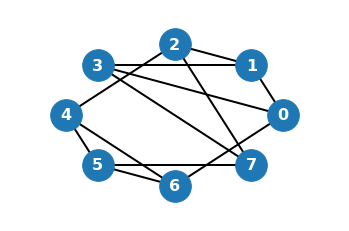

In [14]:
V = [0,1,2,3,4,5,6,7]
# V = [0,1,2,3,4,5,6,7,8,9]
# V = [0,1,2,3,4,5,6,7,8,9,10,11]

V.sort()
print(V)

E = E0[4]


target_graph = nx.Graph()
target_graph.add_nodes_from(V)
target_graph.add_edges_from(E)

target_graph = nx.Graph()
target_graph.add_nodes_from(V)
target_graph.add_edges_from(E)
pos = nx.circular_layout(target_graph)
options = {
    "with_labels": True,
    "font_size": 16,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 1000,
    "width": 2
}
nx.draw_networkx(target_graph, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [15]:
# N_pm = int(input('Input the number of mixers to be applied in each layer：'))
# p = int(input('Please input the target level depth:'))

N_pm = int(len(V) / 2) + 1  # Set the number of mixers to be applied in each layer based on the number of vertices
p = len(V)  # Set the target depth as the number of vertices in the graph

# # Check if mixers are applied to the specified vertices
# encoder, ansatz = build_ansatz(p, target_graph, N_pm)  # Generate the ansatz circuit
# circ = encoder + ansatz  
# circ.svg()  # Visualize the quantum circuit


In [16]:
max_loss_depth = []  # Maximum expectation value obtained from depth * 200 random initializations for a specific depth
avg_loss_depth = []  # Average expectation value for the same random initializations at a given depth
params_opt_depth = []  # Optimized parameters corresponding to the best expectation value in depth * 100 random initializations
running_time_depth = []  # Time taken to execute depth * 100 random initializations for a given depth
iterations_depth = []  # Average number of iterations consumed for depth * 100 random initializations
data = []  # Collect the value results obtained for each depth
circuit_depth = []  # Average circuit depth consumed in multiple runs for each depth
cnot_depth = []  # Number of CNOT gates required to implement multi-qubit controlled RX gates converted to basic gates at each depth

depth = 1  # Initial depth

while depth <= p:
    times = 200 * depth  # Number of random initializations for each depth
        
    # Randomly initialize seeds and keep the best corresponding parameters
    total_SEED = [] 
    for i in range(0, times):
        total_SEED.append(random.randint(1, 25000))
        
#     total_SEED = [15121, 10357, 11041, 2455, 306, 3121, 12164, 17832, 19168, 3437, 20192, 19424, 17215, 23340, 14757, 8176, 4502, 10598, 11080, 13326]
    my_logger.info('depth = {}, random seeds total_SEED = {}'.format(depth, total_SEED))


    start_time = time.time()  # Record the start time for optimization
    params_opt, max_loss, avg_loss, value, avg_iterations, avg_depth, avg_cnot = search_optimized_parameters(depth, target_graph, times, total_SEED)
    end_time = time.time()  # Record the end time
    delta = end_time - start_time  # Calculate the total execution time
    my_logger.info('start_time = {}'.format(start_time))
    my_logger.info('end_time = {}'.format(end_time))
    my_logger.info('delta = {}'.format(delta))
    my_logger.info('\n')
    
    # Store the results for the current depth
    iterations_depth.append(avg_iterations)
    max_loss_depth.append(max_loss)
    avg_loss_depth.append(avg_loss)
    params_opt_depth.append(params_opt)
    running_time_depth.append(delta)
    data.append(value)
    circuit_depth.append(avg_depth)
    cnot_depth.append(avg_cnot)
    
    depth = depth + 1  # Increase the number of layers for the QAOA+ ansatz
    
#     if (max_loss == beta_G - 0.1) and depth >= 5:
#         depth = p + 1
#     else:
#         depth = depth + 1


depth = 1, random seeds total_SEED = [8705, 17825]



The 1-th global random initialization
SEED = 8705, initial_beta = [0.03463896], initial_gamma = [0.6975834]
root_node = 7
Shortest paths from vertex 7 to other vertices, grouped by distance:
Vertices at distance 0: [7]
Vertices at distance 1: [2, 3, 5]
Vertices at distance 2: [0, 1, 4, 6]
For N_pm = 5, the vertices where the mixer can be applied: [0, 2, 3, 5, 7]
weight = [0.6975834  0.03463896]
lr = 0.05,ITR = 600
train_step = 50, loss = -2.858920097351074
Convergence condition met, iteration steps used = 71, change in expectation function loss0 = [-0.0014993122, -0.008936517, -0.021601202, -0.039615404, -0.063063785, -0.091996565, -0.12642394, -0.16631107, -0.21157414, -0.26207855, -0.31763896, -0.37802017, -0.44294038, -0.5120755, -0.58506423, -0.6615148, -0.7410113, -0.8231209, -0.9073999, -0.99340045, -1.0806752, -1.1687825, -1.2572894, -1.3457751, -1.4338332, -1.5210742, -1.6071272, -1.6916428, -1.774296, -1.8547884, -1.9328512

In [17]:
my_logger.info('cnot_depth = {}'.format(cnot_depth)) # 用于计算CNOT个数
my_logger.info('\n')

cnot_depth = [90.0, 180.0]




In [18]:
my_logger.info('avg_circuit_depth = {}'.format(circuit_depth ))
my_logger.info('\n')

avg_circuit_depth = [16.0, 32.0]




In [19]:
my_logger.info('data = {}'.format(data))
my_logger.info('\n')
my_logger.info('max_loss_depth = {}'.format(max_loss_depth))
my_logger.info('\n')
my_logger.info('avg_loss_depth = {}'.format(avg_loss_depth))
my_logger.info('\n')

my_logger.info('running_time_depth = {}'.format(running_time_depth))
my_logger.info('\n')
my_logger.info('params_opt_depth = {}'.format(params_opt_depth))
my_logger.info('\n')
my_logger.info('iterations_depth = {}'.format(iterations_depth))

data = [[2.99922, 1.98991], [2.97768, 2.99973]]


max_loss_depth = [2.99922, 2.99973]


avg_loss_depth = [2.49456, 2.98871]


running_time_depth = [8.92702317237854, 7.56835675239563]


params_opt_depth = [[[[3.114538], [0.6975834]]], [[[-0.005129943, 3.1561842], [1.8616792, 3.002283]]]]


iterations_depth = [66.5, 32.0]
